<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Job_search_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import quantecon as qe
from interpolation import interp
from numpy.random import randn
from numba import njit, jitclass, prange, float64, int32, boolean

In [4]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('α', float64),          # job separation rate
    ('β', float64),          # discount factor
    ('sigma', float64),          # scale parameter in lognormal distribution
    ('mu', float64),          # location parameter in lognormal distribution
    ('w_grid', float64[:]),  # grid of points for fitted VFI
    ('w_draws', float64[:]),  # draws of wages for Monte Carlo
    ('n', int32),
    ('m', float64),
    ('s', float64),
    ('uniform', boolean)

]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self, 
            c=1,
            α=0.1,
            β=0.96,
            sigma = 0.5,
            mu = 2.5,
            grid_min=1e-10,
            grid_max=5,
            grid_size=100,
            n_draws=1000,
            m = 2.0,
            s = 1.0,
            uniform=False):
      
        self.c, self.α, self.β = c, α, β
        self.mu, self.sigma, self.n = mu, sigma, n_draws
        self.m, self.s, self.uniform = m, s, uniform
        self.w_grid = np.linspace(grid_min, grid_max, grid_size)
        self.w_draws = self._draws() if not uniform else self._drawsUniform()

    def _draws(self):
      np.random.seed(1234)
      z = np.random.randn(self.n)
      w_draws = np.exp(self.mu + self.sigma * z)
      return w_draws
    
    def _drawsUniform(self):
      np.random.seed(1234)
      w_draws = np.random.uniform(self.m - self.s, self.m + self.s, size = self.n)
      return w_draws

    def update(self, v, d):

        # Simplify names
        c, α, β = self.c, self.α, self.β
        w = self.w_grid
        u = lambda x: np.log(x)

        # Interpolate array represented value function
        vf = lambda x: interp(w, v, x)

        # Update d using Monte Carlo to evaluate integral
        d_new = np.mean(np.maximum(vf(self.w_draws), u(c) + β * d))

        # Update v
        v_new = u(w) + β * ((1 - α) * v + α * d)

        return v_new, d_new

In [5]:
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w_grid)    # Initial guess of v
    d = 1                           # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1
    if i >= max_iter:
      raise ValueError('Iteration failed.')
    return v, d

In [6]:
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """
    u = lambda x: np.log(x)

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w_grid):
        if v[i] > h:
            w_bar = wage
            break
    return w_bar

In [7]:
%%time

mu_vals = np.linspace(0.0, 2.0, 15)
w_bar_vals = np.empty_like(mu_vals)
for i, mu in enumerate(mu_vals):
  mcm = mcm = McCallModelContinuous(mu = mu)
  w_bar_vals[i] = compute_reservation_wage(mcm)

CPU times: user 4.68 s, sys: 28.2 ms, total: 4.7 s
Wall time: 4.71 s


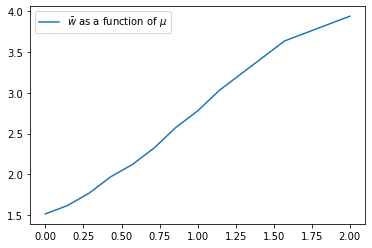

In [8]:
plt.plot(mu_vals, w_bar_vals, label=r'$\bar{w}$ as a function of $\mu$')
plt.legend();

In [11]:
%%time

s_vals = np.linspace(1.0, 2.0, 15)
w_bar_vals = np.empty_like(s_vals)
for i, s in enumerate(s_vals):
  mcm = mcm = McCallModelContinuous(s = s, uniform=True)
  w_bar_vals[i] = compute_reservation_wage(mcm)

CPU times: user 404 ms, sys: 1.04 ms, total: 405 ms
Wall time: 407 ms


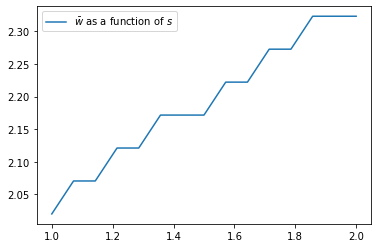

In [12]:
plt.plot(s_vals, w_bar_vals, label=r'$\bar{w}$ as a function of $s$')
plt.legend();